In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# hyper parameters
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MNIST = False

# get data
train_data = torchvision.datasets.MNIST(
    root='./data/mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST
)
test_data = torchvision.datasets.MNIST(
    root='./data/mnist',
    train=False
)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.
test_x.requires_grad_(True)
test_y = test_data.test_labels[:2000]

train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

D:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


D:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])


D:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000])


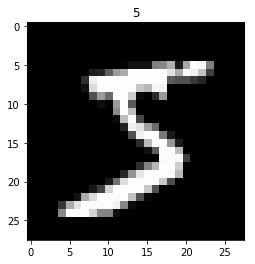

In [16]:
# check data
print(train_data.train_data.size())
print(train_data.train_labels.size())
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])

In [34]:
# define CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(  # (1, 28, 28)
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,  # if stride=1, padding=(kernel_size-1)/2
            ),  # -> (16, 28, 28)
            nn.ReLU(),  # -> (16, 28, 28)
            nn.MaxPool2d(kernel_size=2)  # -> (16, 14, 14)
        )
        self.conv2 = nn.Sequential(  
            nn.Conv2d(16, 32, 5, 1, 2),  # -> (32, 14, 14)
            nn.ReLU(),  # -> (32, 14, 14)
            nn.MaxPool2d(2)  # -> (32, 7, 7)
        )
        self.out = nn.Linear(32*7*7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)  # (batch, 32, 7, 7)
        x = x.view(x.size(0), -1)  # (batch, 32*7*7)
        output = self.out(x)
        return output
    
cnn = CNN()

In [35]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

In [39]:
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x.requires_grad_(True)
        output = cnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(),
                  '| test accuracy: ', accuracy.numpy())

test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')